In [1]:
import pandas as pd

# Import package for Malay articles
import malaya

# Import packages for English articles
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import text2emotion as te

C:\Users\lilia\AppData\Local\Programs\Python\Python39\lib\site-packages\malaya_boilerplate\frozen_graph.py:24: UserWarning: Cannot import beam_search_ops from Tensorflow Addons, `deep_model` for stemmer will not available to use, make sure Tensorflow Addons version >= 0.12.0
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Get scraped articles
df = pd.read_excel("scraped_articles.xlsx", sheet_name="Sheet2")
df = df.drop(["date", "google_date"], axis=1)
df.converted_date = pd.to_datetime(df.converted_date, errors='ignore')

In [3]:
# Get all Malay language articles
bm_df = df[df.lang == "BM"]
strings = bm_df.article.tolist()

# Sentiment analysis with BERT
model_sentiment = malaya.sentiment.transformer(model='bert')
sentiment = model_sentiment.predict_proba(strings)

# Emotion analysis with BERT
model_emote = malaya.emotion.transformer(model='bert')
emotion = model_emote.predict_proba(strings)

bm_df = pd.concat(
    [bm_df.reset_index(), pd.DataFrame(sentiment), pd.DataFrame(emotion)], 
    axis = 1)

downloading frozen model to C:\Users\lilia\Malaya\sentiment\bert\model.pb


100%|██████████| 426/426 [00:37<00:00, 11.5MB/s]


downloading frozen vocab to C:\Users\lilia\Malaya\sentiment\bert\sp10m.cased.bert.vocab


184%|██████████| 1.00/0.54 [00:00<00:00, 1.75MB/s]


downloading frozen tokenizer to C:\Users\lilia\Malaya\sentiment\bert\sp10m.cased.bert.model


135%|██████████| 1.00/0.74 [00:00<00:00, 1.47MB/s]


downloading frozen model to C:\Users\lilia\Malaya\emotion\bert\model.pb


100%|██████████| 426/426 [00:32<00:00, 13.3MB/s]


downloading frozen vocab to C:\Users\lilia\Malaya\emotion\bert\sp10m.cased.bert.vocab


184%|██████████| 1.00/0.54 [00:00<00:00, 1.77MB/s]


downloading frozen tokenizer to C:\Users\lilia\Malaya\emotion\bert\sp10m.cased.bert.model


135%|██████████| 1.00/0.74 [00:00<00:00, 1.47MB/s]


In [4]:
# Get all English language articles
col_names = ["positive", "negative", "neutral", "anger", "fear", 
            "happy", "surprise", "sadness"]
empty_df = pd.DataFrame(columns=col_names)
eng_df = pd.concat([df[df.lang == "EN"].reset_index(), empty_df], axis = 1)

# Sentiment and emotion analysis for English
model_eng = SentimentIntensityAnalyzer()

for i, string in enumerate(eng_df.article):
    sentiment = model_eng.polarity_scores(string)
    eng_df["positive"][i] = sentiment["pos"]
    eng_df["negative"][i] = sentiment["neg"]
    eng_df["neutral"][i]= sentiment["neu"]

    emotion = te.get_emotion(string)
    eng_df["anger"][i] = emotion["Angry"]
    eng_df["fear"][i] = emotion["Fear"]
    eng_df["happy"][i] = emotion["Happy"]
    eng_df["surprise"][i] = emotion["Surprise"]
    eng_df["sadness"][i] = emotion["Sad"]

In [5]:
final_df = bm_df.append(eng_df, ignore_index=True) # Merge results
# Standardise similarly named media sources
final_df.media = final_df.media.replace(
    ["Malaysia Kini", "theSundaily.my", "Pages | Malaysiakini", "The Sun daily" ], 
    ["Malaysiakini", "The Sun Daily", "Malaysiakini", "The Sun Daily"])

# Analysis of results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

In [4]:
# Ensure all data is the correct type
final_df = final_df.astype({col:"float64" for col in col_names})
final_df["year"] = final_df.converted_date.dt.year

eng_df = final_df[final_df.lang == "EN"]
bm_df = final_df[final_df.lang == "BM"]

language = ["Malay", "English"]

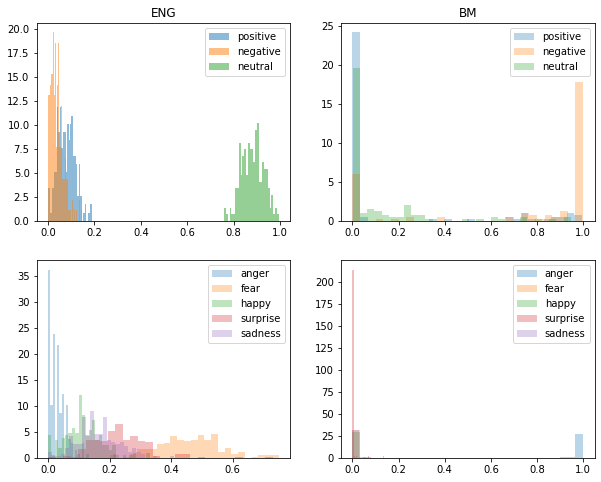

In [9]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
for i in range(3):
    plt.hist(eng_df[col_names[i]], density=True, label=col_names[i], bins=30, alpha=.5)
plt.legend()
plt.title("ENG")

plt.subplot(2,2,2)
for i in range(3):
    plt.hist(bm_df[col_names[i]], density=True, label=col_names[i],bins=30,  alpha=.3)
plt.legend()
plt.title("BM")

plt.subplot(2,2,3)
for i in range(3,len(col_names)):
    plt.hist(eng_df[col_names[i]], density=True, label=col_names[i],bins=30,  alpha=.3)
plt.legend()

plt.subplot(2,2,4)
for i in range(3,len(col_names)):
    plt.hist(bm_df[col_names[i]], density=True, label=col_names[i],bins=30, alpha=.3)
plt.legend()
plt.show()

In [5]:
# Group articles by media source
eng_group = eng_df.groupby(by = "media").mean()
bm_group = bm_df.groupby(by = "media").mean()

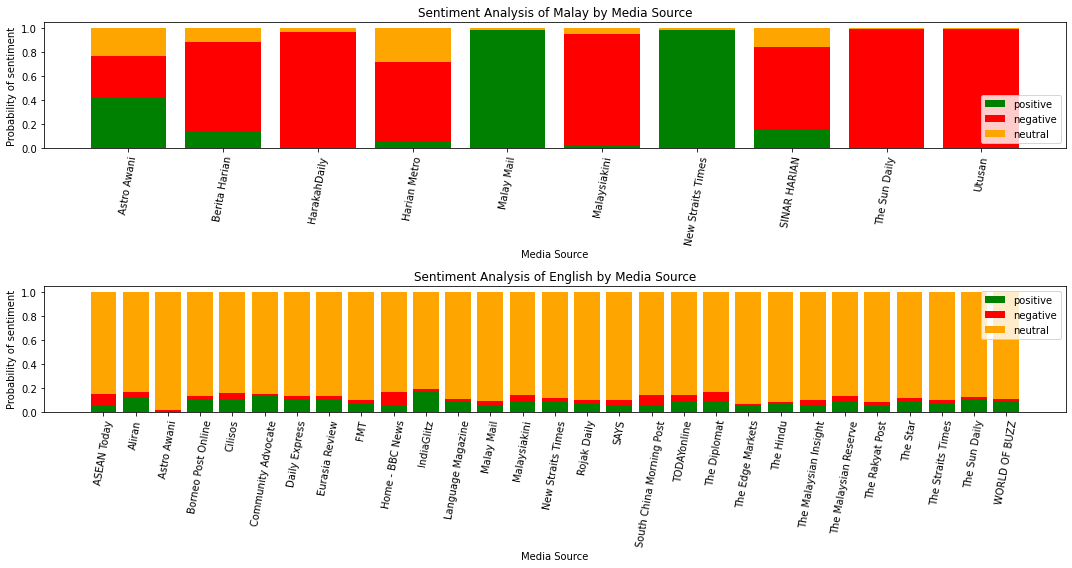

In [6]:
plt.figure(figsize=(15, 8))
for i, df in enumerate([bm_group, eng_group]):
    plt.subplot(2,1,i+1)
    ind = df.index
    bottom = 0
    for sentiment, media, color in zip ([df[col] for col in col_names[:3]],
                                    [col for col in col_names[:3]],
                                    ["green", "red", "orange"]):
        plt.bar(ind, sentiment, label=media, color = color, bottom=bottom)
        bottom += sentiment
    plt.legend()
    plt.xlabel("Media Source")
    plt.ylabel("Probability of sentiment")
    plt.title(f"Sentiment Analysis of {language[i]} by Media Source")
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

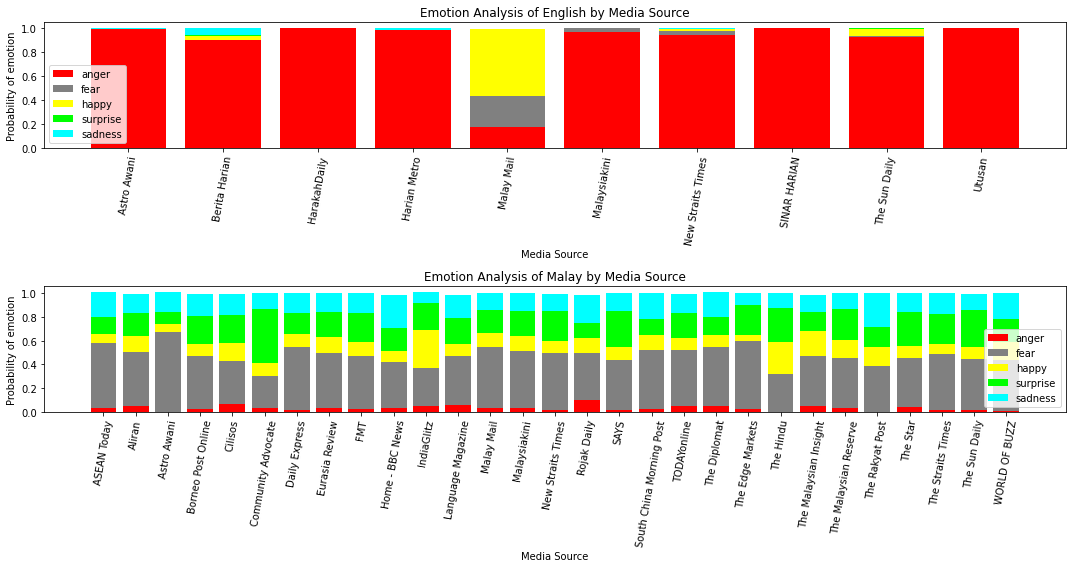

In [39]:
plt.figure(figsize=(15, 8))
for i, df in enumerate([bm_group, eng_group]):
    plt.subplot(2,1,i+1)
    ind = df.index
    bottom = 0
    for sentiment, media, color in zip ([df[col] for col in col_names[3:]],
                                    [col for col in col_names[3:]],
                                    ["red", "grey", "yellow", "lime", "cyan"]):
        plt.bar(ind, sentiment, label=media, color = color, bottom=bottom)
        bottom += sentiment
    plt.legend()
    plt.title(f"Emotion Analysis of {language[i]} by Media Source")
    plt.xlabel("Media Source")
    plt.ylabel("Probability of emotion")
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

In [32]:
# Group articles by year
eng_year = eng_df.groupby("year").count()
bm_year = bm_df.groupby("year").count()
year_df = pd.DataFrame({
    'lang': ["EN"]*len(eng_year)+["BM"]*len(bm_year), 
    'count': list(eng_year.iloc[:,0])+list(bm_year.iloc[:,0]), 
    'year': list(eng_year.index)+list(bm_year.index)})

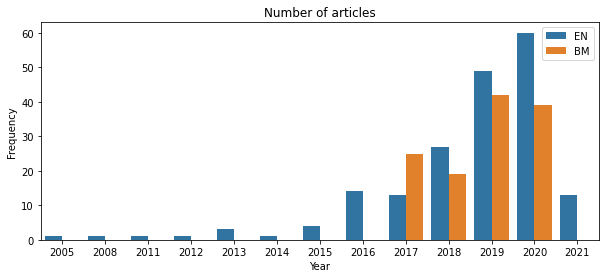

In [36]:
plt.figure(figsize=(10,4))
sns.barplot(data=year_df, x='year', hue='lang', y='count')
plt.legend()
plt.title("Number of articles")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

In [8]:
# Group articles by year to show average data
eng_year = eng_df.groupby("year").mean()
bm_year = bm_df.groupby("year").mean()

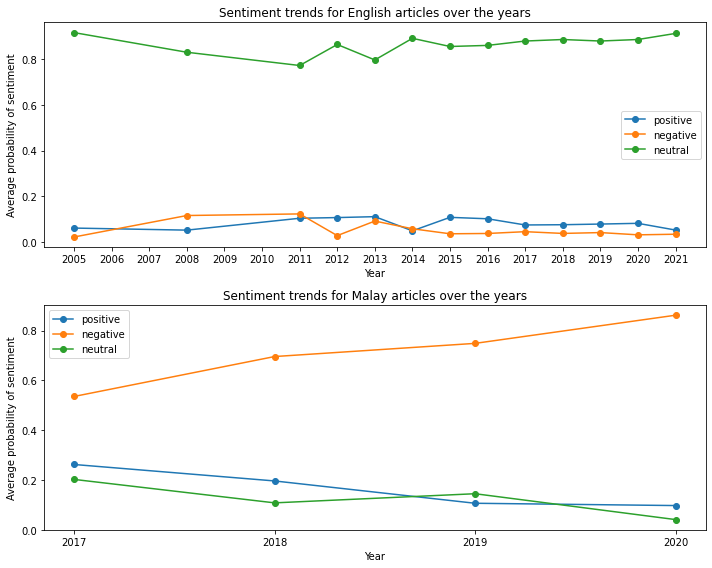

In [12]:
plt.figure(figsize=(10,8))
language = ["English", "Malay"]
for i, df in enumerate([eng_year, bm_year]):
    plt.subplot(2,1,i+1)
    for col in col_names[:3]:
        plt.plot(df.index, df[col], label = col, marker='o')
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Average probability of sentiment")
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title(f"Sentiment trends for {language[i]} articles over the years")
plt.tight_layout()
plt.show()

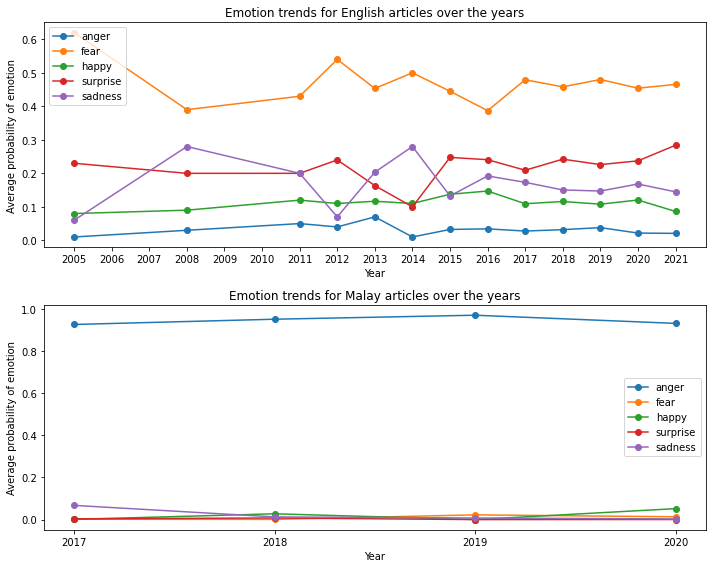

In [13]:
plt.figure(figsize=(10,8))
language = ["English", "Malay"]
for i, df in enumerate([eng_year, bm_year]):
    plt.subplot(2,1,i+1)
    for col in col_names[3:]:
        plt.plot(df.index, df[col], label = col, marker='o')
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Average probability of emotion")
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title(f"Emotion trends for {language[i]} articles over the years")
plt.tight_layout()
plt.show()

# Visually assessing model performance randomly selected article from each language

In [22]:
import numpy as np 

# Choose random index
idx = np.random.randint(0, len(bm_df), size=3)

# 3 randomly selected Malay language articles with results
for i in idx:
    print(f"Article {i+1}\n")
    print(bm_df.article[i])
    print(f"Sentiment: positive {bm_df.positive[i]}, negative {bm_df.negative[i]}, neutral {bm_df.neutral[i]} \n")
    print(f"Emotion:")
    for cat in col_names[3:]:
        print(f"{cat} {bm_df[cat][i]}")

Article 38

  PUTRAJAYA - Mahkamah Persekutuan akan memutuskan pada 11 November ini sama ada memberikan kebenaran kepada seorang peguam untuk mencabar Perlembagaan berhubung kewujudan sekolah vernakular. Hakim Besar Malaya, Tan Sri Azahar Mohamed menetapkan tarikh itu selepas mendengar hujah daripada peguam yang mewakili pihak-pihak dalam permohonan itu. Pempetisyen, Mohd Khairul Azam Abdul Aziz, perlu mendapatkan kebenaran daripada seorang hakim Mahkamah Persekutuan di bawah Perkara 4 (4) Perlembagaan Persekutuan kerana beliau mencabar keupayaan undang-undang persekutuan untuk meluluskan undang-undang. Dalam notis usul yang difailkan pada 23 Oktober lepas, peguam terbabit memohon deklarasi daripada Mahkamah Persekutuan bahawa adalah tidak berperlembagaan untuk Parlimen meluluskan pindaan kepada Seksyen 17 dan 28 Akta Pendidikan 1996 untuk kewujudan berterusan sekolah vernakular. Beliau menamakan Menteri Pendidikan dan Kerajaan Persekutuan sebagai responden.         Berita Telus & Tulu

In [25]:
eng_df = eng_df.reset_index()

# 3 randomly selected Malay language articles with results
for i in idx:
    print(f"Article {i+1}\n")
    print(eng_df.article[i])
    print(f"Sentiment: positive {eng_df.positive[i]}, negative {eng_df.negative[i]}, neutral {eng_df.neutral[i]} \n")
    print(f"Emotion:")
    for cat in col_names[3:]:
        print(f"{cat} {eng_df[cat][i]}")

Article 38

Saturday, 11 Jan 2020 graduates HAPPY New Year and welcome to the new decade of hope and aspirations. Hopefully all of you have been well rested through the holiday season and recharged to face the new decade with optimism and a smile on your face. I am well rested, thank you. In fact I spent most of my time on the couch binging through many movies and Streaming series. My absolute favourite has to be the eight-episode The Mandalorian, with the cute 50-year-old baby Yoda and the Ugnaught farmer, Kuiil who will close his speech with a “I have spoken” finale. The main star of the show, the Mandalorian, a bounty hunter who lives by the Mandalorian code of life and it is summed up in one simple phrase “This is the way”. We are only 11 days into 2020 and what a start! Our Education Minister resigned, India authorities asking their importers to boycott buying palm oil from Malaysia, the United States assassinating an general in Baghdad. Ukraine jetliner crashing after taking off 